### Predicting which passengers survived the sinking of the Titanic

In [2]:
import pandas as pd
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

test = pd.read_csv("https://dsserver-prod-resources-1.s3.amazonaws.com/185/test.csv?versionId=Mm10pgEOn5abHw7XSFjQADXds3NwWTWs")
test_shape = test.shape
train = pd.read_csv("https://dsserver-prod-resources-1.s3.amazonaws.com/185/train.csv?versionId=ReBfOxrWiJw0Otzbepa6otqacarq2QNY")
train_shape = train.shape

In [3]:
test_shape, train_shape

((418, 11), (891, 12))

Brief data dictionary

* PassengerID 
* Survived - Whether the passenger survived or not and the value we are predicting (0=No, 1=Yes)
* Pclass - The class of the ticket the passenger purchased (1=1st, 2=2nd, 3=3rd)
* Sex - The passenger's sex
* Age - The passenger's age in years
* SibSp - The number of siblings or spouses the passenger had aboard the Titanic
* Parch - The number of parents or children the passenger had aboard the Titanic
* Ticket - The passenger's ticket number
* Fare - The fare the passenger paid
* Cabin - The passenger's cabin number
* Embarked - The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton)

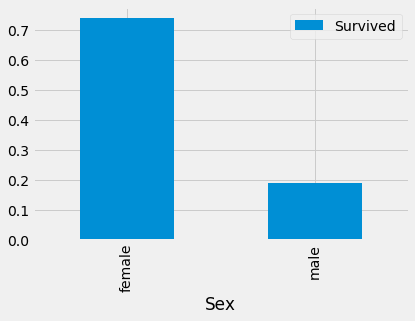

In [6]:
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')

sex_pivot = train.pivot_table(index="Sex",values="Survived")
sex_pivot.plot.bar()
plt.show()

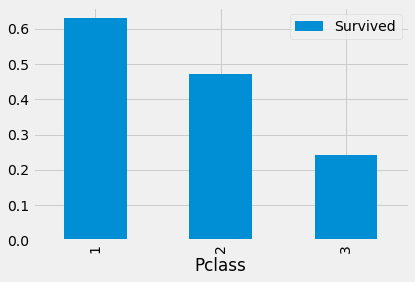

In [7]:
class_pivot = train.pivot_table(index="Pclass",values="Survived")
class_pivot.plot.bar()
plt.show()

Compare age frequency between the survived vs not survived

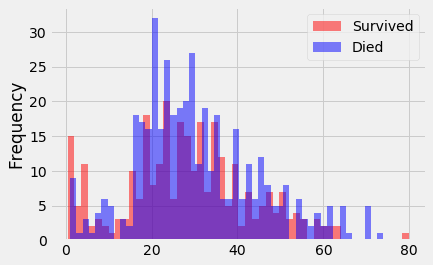

In [8]:
survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]
survived["Age"].plot.hist(alpha=0.5,color='red',bins=50)
died["Age"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['Survived','Died'])
plt.show()

We can see that in some age ranges more passengers survived. This means a separation of this continuous feature will be useful for modeling.


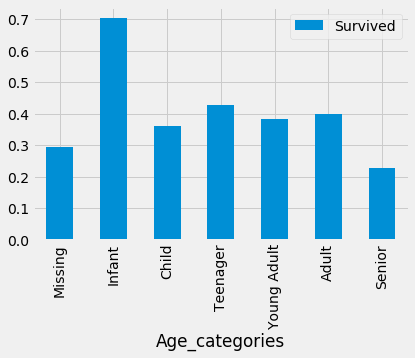

In [66]:
cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]

def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

train = process_age(train,cut_points,label_names)
test = process_age(test,cut_points,label_names)

pivot = train.pivot_table(index="Age_categories",values='Survived')
pivot.plot.bar()
plt.show()

For a column that doesn't have any ordered relationship among its values, we need to transform it into dummy volumns for each unique value. 

In [67]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

train = create_dummies(train,"Pclass")
test = create_dummies(test,"Pclass")

train = create_dummies(train,"Sex")
test = create_dummies(test,"Sex")

train = create_dummies(train,"Age_categories")
test = create_dummies(test,"Age_categories")

Fitting a model

In [68]:
from sklearn.model_selection import train_test_split

holdout = test 

columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']
all_X = train[columns]
all_y = train['Survived']

train_X, test_X, train_y, test_y = train_test_split(all_X, all_y, test_size=0.20,random_state=0)

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
lr.fit(train_X, train_y)

predictions = lr.predict(test_X)
accuracy = accuracy_score(test_y, predictions)

print(accuracy)

0.8100558659217877


Given that this data set is quite small, there is a good chance that our model is overfitting. Thus let's use k-fold cross validation to improve model performance.

In [70]:
from sklearn.model_selection import cross_val_score
import numpy as np

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy = np.mean(scores)

print(scores)
print(accuracy)

[0.8        0.81111111 0.7752809  0.87640449 0.80898876 0.78651685
 0.76404494 0.76404494 0.83146067 0.80681818]
0.8024670865963002


Average accuracy score from cross validation is 80.2%, which is not far from the 81.0% from the simple train/test split, however this will not always be the case, that's why we should use cross-validation to make sure the error metrics from this model are not overfit (so the model is valid/accurate)

In [71]:
columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']
lr = LogisticRegression()
lr.fit(all_X,all_y)
holdout_predictions = lr.predict(holdout[columns])
# holdout_predictions

In [72]:
submission_df = {"PassengerId": holdout["PassengerId"],
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

#submission.to_csv("submission.csv",index=False)

The fact that the accuracy on the holdout data is 75.6% compared with the 80.2% accuracy with cross-validation indicates that the model is overfitting slightly to the training data.



### Feature selection/engineering

In [73]:
import pandas as pd

train = pd.read_csv('https://dsserver-prod-resources-1.s3.amazonaws.com/186/train.csv?versionId=muCZ0xYke4L7OacmbRsSLwtMKwhSnkpt')
holdout = pd.read_csv('https://dsserver-prod-resources-1.s3.amazonaws.com/186/test.csv?versionId=9_gAlNs5sd0L12eSfh9Su6FgGNO7RNlE')

def process_age(df):
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df
train = process_age(train)
holdout = process_age(holdout)

for column in ["Age_categories","Pclass","Sex"]:
    train = create_dummies(train,column)
    holdout = create_dummies(holdout,column)

print(train.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male'],
      dtype='object')


List of Unused columns

* SibSp - The number of siblings or spouses the passenger had aboard the Titanic
* Parch - The number of parents or children the passenger had aboard the Titanic
* Ticket - The passenger's ticket number
* Fare - The fair the passenger paid
* Cabin - The passengers cabin number
* Embarked - The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton)

In [74]:
columns = ['SibSp','Parch','Fare','Cabin','Embarked']
print(train[columns].describe(include='all',percentiles=[]))

             SibSp       Parch        Fare Cabin Embarked
count   891.000000  891.000000  891.000000   204      889
unique         NaN         NaN         NaN   147        3
top            NaN         NaN         NaN    G6        S
freq           NaN         NaN         NaN     4      644
mean      0.523008    0.381594   32.204208   NaN      NaN
std       1.102743    0.806057   49.693429   NaN      NaN
min       0.000000    0.000000    0.000000   NaN      NaN
50%       0.000000    0.000000   14.454200   NaN      NaN
max       8.000000    6.000000  512.329200   NaN      NaN


* SibSp, Parch and Fare: standard numeric columns with no missing values => Leave them
* Cabin: Has values for only 204 of the 891 rows. Most of the values are unique => Leave it
* Embarked: standard categorical column with minimal missing value => Leave it
    * Fill missing values with the most common value, "S" which occurs 644 times

In [75]:
from sklearn.preprocessing import minmax_scale

holdout["Fare"] = holdout["Fare"].fillna(train["Fare"].mean())

train["Embarked"] = train["Embarked"].fillna("S")
holdout["Embarked"] = holdout["Embarked"].fillna("S")

train = create_dummies(train,"Embarked")
holdout = create_dummies(holdout,"Embarked")

columns = ["SibSp","Parch","Fare"]
for col in columns:
    train[col + "_scaled"] = minmax_scale(train[col])
    holdout[col + "_scaled"] = minmax_scale(holdout[col])

#### Determining the most relevant features

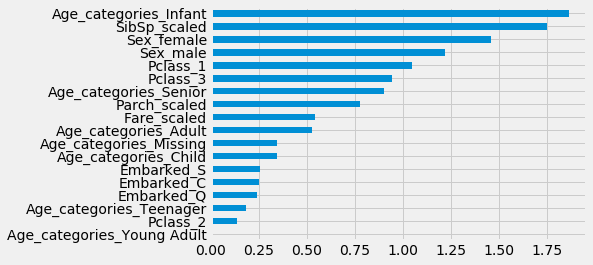

In [76]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled']
lr = LogisticRegression()
lr.fit(train[columns],train['Survived'])

coefficients = lr.coef_

feature_importance = pd.Series(coefficients[0], index=train[columns].columns)
# Whether the value is positive or negative isn't as important in this case, relative to the magnitude of the value.
feature_importance = feature_importance.abs().sort_values()
feature_importance.plot.barh()
plt.show()

Select the top 8 features for fitting a new model

In [91]:
from sklearn.model_selection import cross_val_score

columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']

all_X = train[columns]
all_y = train['Survived']

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy = scores.mean()
print(accuracy)

0.8148019521053229


The cross validation score of 81.48% is higher than the cross validation score for the model in the previous one, which had a score of 80.2%.

Let's check whether prediction result for this model yields a higher accuracy score.

In [97]:
lr = LogisticRegression()
lr.fit(all_X,all_y)

holdout_predictions = lr.predict(holdout[columns])

submission_df = {"PassengerId": holdout["PassengerId"],
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

#submission.to_csv("submission_1.csv",index=False)

77.0% is better than the previous model; however, let's make more improvements.

#### Feature engineering through Binning

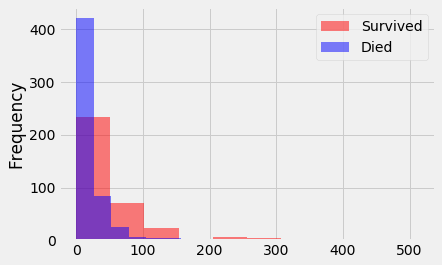

In [102]:
survived_temp = train[train["Survived"] == 1]
died_temp = train[train["Survived"] == 0]
survived_temp["Fare"].plot.hist(alpha=0.5,color='red',bins=10)
died_temp["Fare"].plot.hist(alpha=0.5,color='blue',bins=10)
plt.legend(['Survived','Died'])
plt.show()

Separate the feature into four bins to capture some patterns from the data

In [105]:
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df,cut_points,label_names):
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

cut_points = [0,12,50,100,1000]
label_names = ["0-12","12-50","50-100","100+"]

train = process_fare(train,cut_points,label_names)
holdout = process_fare(holdout,cut_points,label_names)

train = create_dummies(train,"Fare_categories")
holdout = create_dummies(holdout,"Fare_categories")

#### Feature engineering through text columns

In [106]:
titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}

extracted_titles = train["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
train["Title"] = extracted_titles.map(titles)
extracted_titles = holdout["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
holdout["Title"] = extracted_titles.map(titles)

# First letter is representative of the type of cabin
train["Cabin_type"] = train["Cabin"].str[0]
train["Cabin_type"] = train["Cabin_type"].fillna("Unknown")

holdout["Cabin_type"] = holdout["Cabin"].str[0]
holdout["Cabin_type"] = holdout["Cabin_type"].fillna("Unknown")

for column in ["Title","Cabin_type"]:
    train = create_dummies(train,column)
    holdout = create_dummies(holdout,column)

#### Collinearity features

Collinearity causes a small amount of overfitting

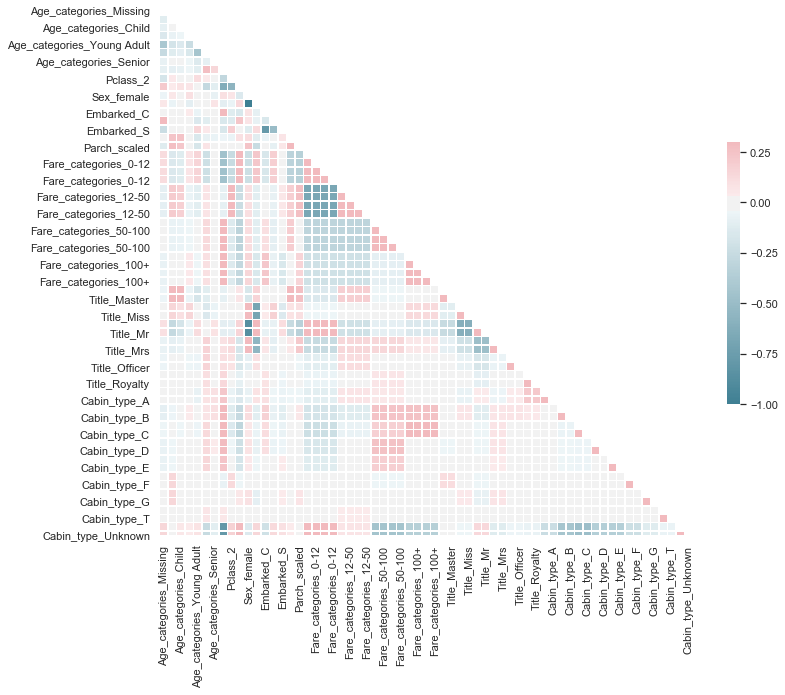

In [115]:
import numpy as np
import seaborn as sns
sns.set(style="white")

def plot_correlation_heatmap(df):
    corr = df.corr()
    
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

    
columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_categories_0-12',
       'Fare_categories_12-50','Fare_categories_50-100', 'Fare_categories_100+',
       'Title_Master', 'Title_Miss', 'Title_Mr','Title_Mrs', 'Title_Officer',
       'Title_Royalty', 'Cabin_type_A','Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E','Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown']

plot_correlation_heatmap(train[columns])

##### There is a high correlation between Sex_female/Sex_male and Title_Miss/Title_Mr/Title_Mrs. 
##### Let's remove the columns Sex_female and Sex_male since the title data may be more nuanced.

##### Also Remove Pclass_2, Age_categories_Teenager, Fare_categories_12-50, Title_Master, Cabin_type_A

#### Feature selection using RFECV (Recursive feature elimination with cross-validation)

The RFECV class starts by training a model using all of your features and scores it using cross validation. It then uses the logit coefficients to eliminate the least important feature, and trains and scores a new model. At the end, the class looks at all the scores, and selects the set of features which scored highest.

In [117]:
from sklearn.feature_selection import RFECV

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_scaled',
       'Parch_scaled', 'Fare_categories_0-12', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown']

all_X = train[columns]
all_y = train["Survived"]

lr = LogisticRegression()
selector = RFECV(lr,cv=10)
selector.fit(all_X,all_y)

optimized_columns = all_X.columns[selector.support_]
optimized_columns

Index(['Pclass_3', 'SibSp_scaled', 'Title_Mr', 'Title_Officer'], dtype='object')

In [128]:
# train a model using cross validation using these columns and check the score

all_X = train[optimized_columns]
all_y = train["Survived"]
lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy = scores.mean()

accuracy

0.8215063556917489

82.2%, a modest improvement compared to the 81.5% from the earlier model

In [122]:
lr = LogisticRegression()
lr.fit(all_X,all_y)
holdout_predictions = lr.predict(holdout[optimized_columns])

submission_df = {"PassengerId": holdout["PassengerId"],
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

#submission.to_csv("submission_2.csv",index=False)

Accuracy score on the test set is 78.0%, 1% increase from the earlier model

### Model Selection / Tuning using Grid search

Searched for a model with the highest accuracy

In [17]:
import pandas as pd
train = pd.read_csv('https://dsserver-prod-resources-1.s3.amazonaws.com/187/train_modified.csv?versionId=X3BQApcJGVeEVmMt3HBHGwB1RORCz.Tp')
holdout = pd.read_csv('https://dsserver-prod-resources-1.s3.amazonaws.com/187/holdout_modified.csv?versionId=d64j2uhB9pcQVVe6_aWVNPmCXw10zn4a')

Train models using all the columns in the train dataframe => This will cause a small amount of overfitting due to collinearity but having more features allows for more thoroughly compare algorithms

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

all_X = train.drop(['Survived','PassengerId'],axis=1)
all_y = train['Survived']
lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy_lr = scores.mean()

accuracy_lr

0.823891442515038

82.4%, just a slight improvement

In [137]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)

scores = cross_val_score(knn, all_X, all_y, cv=10)
accuracy_knn = scores.mean()

accuracy_knn

0.7857382816933379

78.6%, worse than the previous score of 82.4%

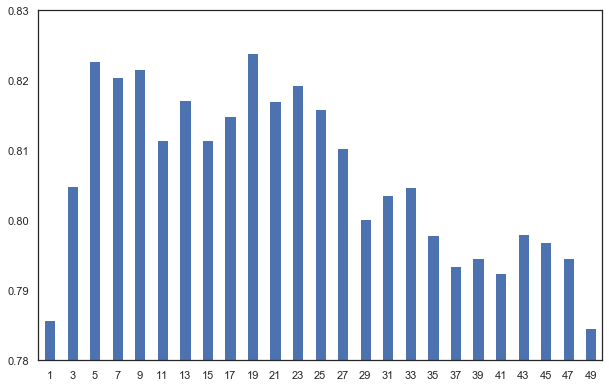

In [138]:
# Hyperparameter Optimization

import matplotlib.pyplot as plt

def plot_dict(dictionary):
    pd.Series(dictionary).plot.bar(figsize=(9,6),
                                   ylim=(0.78,0.83),rot=0)
    plt.show()

knn_scores = dict()
for k in range(1,50,2):
    knn = KNeighborsClassifier(n_neighbors=k)

    scores = cross_val_score(knn, all_X, all_y, cv=10)
    accuracy_knn = scores.mean()
    knn_scores[k] = accuracy_knn

plot_dict(knn_scores)

k value of 5 yields 82.4%, similar to the score from the logistic regression model

In [142]:
# Use scikit Grid Search to automate the previous process

from sklearn.model_selection import GridSearchCV

hyperparameters = {
    "n_neighbors": range(1,20,2),
    "weights": ["distance", "uniform"],
    "algorithm": ['brute'],
    "p": [1,2]
}
knn = KNeighborsClassifier()
grid = GridSearchCV( knn,param_grid = hyperparameters, cv = 10)

grid.fit(all_X, all_y)

grid.best_params_, grid.best_score_, grid.best_estimator_


({'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'},
 0.8282828282828283,
 KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=5, p=1,
                      weights='uniform'))

82.8%, so far the highest accuracy score

In [19]:
holdout_no_id = holdout.drop(['PassengerId'],axis=1)

best_knn = grid.best_estimator_
holdout_predictions = best_knn.predict(holdout_no_id)

submission_df = {"PassengerId": holdout["PassengerId"],
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

# submission.to_csv("submission_1.csv",index=False)

75.6%, lower than the previous score of test set 

#### Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=1)
scores = cross_val_score(clf, all_X, all_y, cv=10)
accuracy_rf = scores.mean()

accuracy_rf

0.8070125411417546

80.7%, not impressive score. Let's try grid search.

In [14]:
from sklearn.model_selection import GridSearchCV

hyperparameters = {"criterion": ["entropy", "gini"],
                   "max_depth": [5, 10],
                   "max_features": ["log2", "sqrt"],
                   "min_samples_leaf": [1, 5],
                   "min_samples_split": [3, 5],
                   "n_estimators": [6, 9]
}

clf = RandomForestClassifier(random_state=1)
grid = GridSearchCV(clf,param_grid=hyperparameters,cv=10)

grid.fit(all_X, all_y)

grid.best_params_, grid.best_score_

C:\Users\shane\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


({'criterion': 'entropy',
  'max_depth': 10,
  'max_features': 'log2',
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 9},
 0.8428731762065096)

84.3%, the highest cross-validation score so far (higher than kNN)

In [21]:
holdout_no_id = holdout.drop(['PassengerId'],axis=1)

best_rf = grid.best_estimator_
holdout_predictions = best_rf.predict(holdout_no_id)

submission_df = {"PassengerId": holdout["PassengerId"],
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

# submission.to_csv("submission_2.csv",index=False)

77.1%, unfortunately not a higher score from a test set of the previous model